In [1]:
import copy
import sys
import time
sys.path.append('/home/diego/python/generative-glm/experiments/')
sys.path.append('/home/diego/python/utils/')

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.glm.mmdglm import MMDGLM
from gglm.glm.torchglm import TorchGLM
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.values import KernelBasisValues
from gglm.metrics import time_rescale_transform

import myplt

%load_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

from nips2 import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

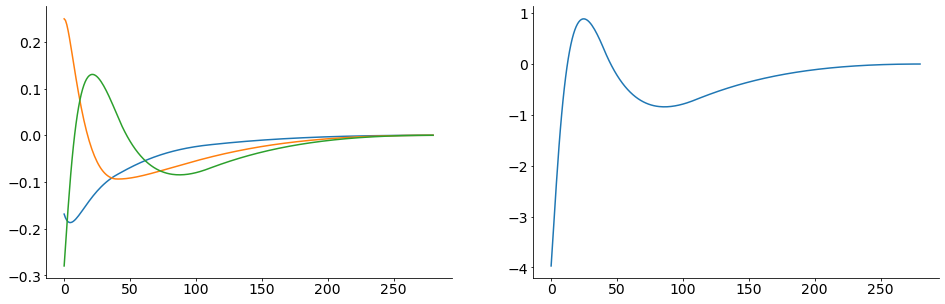

In [2]:
dt = 1
n, last_peak = 3, 40
# eta0 = KernelBasisValues.orthogonalized_raised_cosines(dt, last_peak, n, 8, a=1)
# eta_true = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([4., -2., 10.]))
eta_true = KernelBasisValues.orthogonalized_raised_cosines(dt, last_peak, n, 8, a=1, coefs=np.array([4., -2., 10.]))
t_ker = np.arange(0, eta_true.basis_values.shape[0], 1) * dt
basis = eta_true.basis_values.copy()

fig, (ax1, ax2) = plt.subplots(figsize=(16, 5), ncols=2)
ax1.plot(t_ker, basis)
eta_true.plot(t=t_ker, ax=ax2)

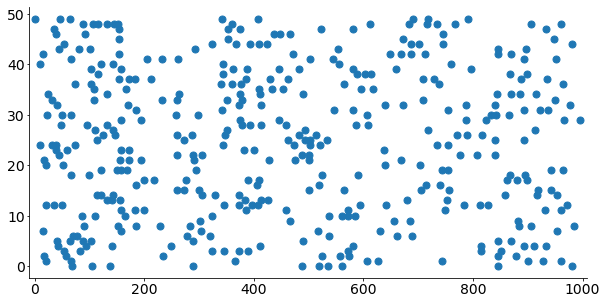

In [3]:
t = np.arange(0, 1000, 1)
np.random.seed(0)
n = 50
glm_true = TorchGLM(u0=-4.5, eta=eta_true)
_, _, mask_spikes = glm_true.sample(t, shape=(n, ))
st = SpikeTrain(t, mask_spikes)
n_spk = np.sum(mask_spikes)
fr = np.mean(np.sum(mask_spikes, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes)
# autocov = np.mean(auto_covariance(mask_spikes, method='fft', subtract_mean=False, 
#                                          stationary_signal=False, biased=False), 1)
isi = st.isi_distribution()
mean_isi = np.mean(isi)

fig, ax = plt.subplots(figsize=(10, 5))
st.plot(ax=ax)

In [4]:
lr = 1e-1
num_epochs = 200
metrics_kwargs = dict(n_batch_fr=60)
n_metrics = 10

u00 = -6
eta0 = KernelBasisValues(basis, [0, basis.shape[0]], dt, coefs=np.array([1., -3., 5.]))

glm = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st.t, st.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=None)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk

_, r_dc_ml = glm.sample_conditioned(st.t, st.mask)
_, _, mask_spikes_ml = glm.sample(st.t, shape=(100, ))
# phi_d = phi_autocov(st.t, torch.from_numpy(r_dc_ml), glm)
# mmd_ml = []
# for ii in range(20):
#     _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st.t, shape=(st.mask.shape[1],))
#     phi_fr = phi_autocov(st.t, torch.from_numpy(r_fr_ml), glm)
#     mmd_ml.append(torch.sum((torch.mean(phi_d, 1) - torch.mean(phi_fr, 1))**2).detach().numpy())

# mean_mmd_ml = np.mean(mmd_ml)
# sd_mmd_ml = np.std(mmd_ml)
# se_mmd_ml = sd_mmd_ml / len(mmd_ml)

 epoch 199 of 200 loss 2261.9423

In [5]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T = st.t[-1] - st.t[0] + st.t[1]
    u_dc, r_dc = model.sample_conditioned(st.t, st.mask)
    nll = -(np.sum(np.log(1 - np.exp(-dt * r_dc[st.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc[~st.mask]))
    return dict(nll=nll)

### MMD

In [7]:
# phi, kernel, lam_mmd, biased, lr, clip = phi_fr, None, 1e-2, False, 1e-2, 1e0
# phi, kernel, lam_mmd, biased, lr, clip = None, ker_fr, 1e1, True, 5e-3, 1e0
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 1e-2, 1e0, 1e4

# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 1e-2, 1e0, 5e3 # 1st

# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e1, False, 2e-2, 1e0, 5e3 # bueno 

phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_sch_heavi, 1e0, False, 5e-2, None, 5e3

beta0, beta1 = 0, 0
n_batch_fr = 200
num_epochs = 100
n_metrics = 1

np.random.seed(1)
torch.manual_seed(1)

u00 = glm.u0 * 1.2
eta0 = glm.eta.copy()
eta0.coefs = eta0.coefs * 1.2

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes), phi=phi, kernel=kernel, 
                                                log_likelihood=False, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_mmd = (metrics_mmd['nll'] - nll_pois_proc_train) / np.log(2) / n_spk
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st.t, shape=(st.mask.shape[1],))
st_fr_mmd = SpikeTrain(st.t, mask_spikes_fr_mmd)

 epoch 99 of 100 loss 1.07334873244

In [8]:
gramian_d_d = kernel(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes))
idx_fr = np.triu_indices(mask_spikes_ml.shape[1], k=1)
idx_fr = (torch.from_numpy(idx_fr[0]), torch.from_numpy(idx_fr[1]))
idx_d = np.triu_indices(mask_spikes.shape[1], k=1)
idx_d = (torch.from_numpy(idx_d[0]), torch.from_numpy(idx_d[1]))

mmd_ml = []

for ii in range(20):
    _, _, mask_spikes_ml = glm.sample(st.t, shape=(n_batch_fr, ))

    gramian_fr_fr = kernel(t, torch.from_numpy(mask_spikes_ml), torch.from_numpy(mask_spikes_ml))
    gramian_d_fr = kernel(t, torch.from_numpy(mask_spikes), torch.from_numpy(mask_spikes_ml))

    if not biased:
        _mmd_ml = torch.mean(gramian_d_d.detach()[idx_d]) + torch.mean(gramian_fr_fr.detach()[idx_fr]) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    else:
        _mmd_ml = torch.mean(gramian_d_d.detach()) + torch.mean(gramian_fr_fr.detach()) \
                          - 2 * torch.mean(gramian_d_fr.detach())
    mmd_ml.append(_mmd_ml)
    
mean_mmd_ml = np.mean(mmd_ml)
sd_mmd_ml = np.std(mmd_ml)
se_mmd_ml = sd_mmd_ml / np.sqrt(len(mmd_ml))

In [9]:
mean_mmd_ml, se_mmd_ml

(0.0096640345, 0.0033670914886837176)

### plot

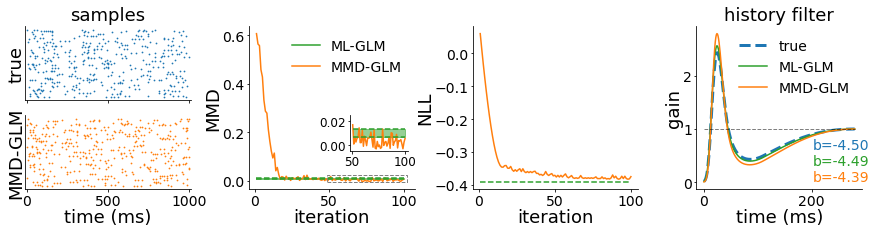

In [59]:
nrows, ncols = 2, 4

fig = plt.figure(figsize=(20 * 0.75, 4 * 0.75))
# ax1 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows)
# ax2 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=nrows)
# axeta = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=nrows)
# axd = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=1)
# axmmd = plt.subplot2grid((nrows, ncols), (1, 3), rowspan=1, sharex=axd)

axd = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=1)
axmmd = plt.subplot2grid((nrows, ncols), (1, 0), rowspan=1, sharex=axd)
ax1 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=nrows)
ax2 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=nrows)
axeta = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=nrows)

ax1.plot(num_epochs, 0, '-', label='ML-GLM', color=palette['ml'])
ax1.plot(iterations_mmd, metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax1.plot([1, num_epochs], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
ax1.plot([1, num_epochs], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
ax1.fill_between([1, num_epochs], mean_mmd_ml - se_mmd_ml, mean_mmd_ml + se_mmd_ml, alpha=0.5, color=palette['ml'])
ax1.set_xlabel('iteration')
ax1.set_ylabel('MMD')
ax1.legend(frameon=False)

axins1 = inset_axes(ax1, width=0.8, height=0.5, bbox_to_anchor=(.3, .1, .7, .4),
                   bbox_transform=ax1.transAxes)
i0 = 50
axins1.plot(iterations_mmd[-i0:], metrics_mmd['mmd'][-i0:], color=palette['mmd'])
axins1.plot([iterations_mmd[-i0], iterations_mmd[-1]], [mean_mmd_ml - se_mmd_ml, mean_mmd_ml - se_mmd_ml], '--', color=palette['ml'])
axins1.plot([iterations_mmd[-i0], iterations_mmd[-1]], [mean_mmd_ml + se_mmd_ml, mean_mmd_ml + se_mmd_ml], '--', color=palette['ml'])
axins1.fill_between([iterations_mmd[-i0], iterations_mmd[-1]], mean_mmd_ml - se_mmd_ml, mean_mmd_ml + se_mmd_ml, alpha=0.5, color=palette['ml'])
axins1.set_yticks([0, 2e-2])
# axins1.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
axins1.tick_params(axis='both', labelsize=12)
axins1.set_ylim(-5e-3, 2.5e-2)
ax1.indicate_inset_zoom(axins1, lw=1, alpha=1, linestyle='--')

ax2.plot([1, num_epochs], [nll_normed_ml[-1], nll_normed_ml[-1]], '--', label='ML-GLM', color=palette['ml'])
ax2.plot(iterations_mmd, nll_normed_mmd, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax2, xlabel='iteration', ylabel='NLL')

lw = 1.5
glm_true.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=3, linestyle='--', label='true', color=palette['d'])
glm.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=lw, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=lw, label='MMD-GLM', color=palette['mmd'])
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', lw=1, alpha=0.5)
axeta.set_title('history filter')
axeta.set_xlabel('time (ms)'); axeta.set_ylabel('gain')
axeta.legend(frameon=False)
# axeta.set_ylim(-0.5, 3)

axeta.text(0.7, 0.25, 'b=' + str(np.round(glm_true.u0, 2)) + '0', color=palette['d'], transform=axeta.transAxes, fontsize=b_size)
axeta.text(0.7, 0.15, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=axeta.transAxes, fontsize=b_size)
axeta.text(0.7, 0.05, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=axeta.transAxes, fontsize=b_size)

# b_size = 14
# axbias = inset_axes(axeta, width=0.8, height=0.2, bbox_to_anchor=(.3, .1, .7, .7), bbox_transform=axeta.transAxes)
# axbias.scatter([0, 1, 2], [glm_true.u0, glm.u0, mmdglm.u0], marker='_', color=[palette['d'], palette['ml'], palette['mmd']])
# axbias.set_xticks([0, 1, 2])
# axbias.set_xticklabels(['true', 'ML-GLM', 'MMD-GLM'], rotation=60)

ms = 1.5
axd.set_title('samples')
axd.set_ylabel('true')
st.plot(ax=axd, marker='.', ms=ms, color=palette['d'])
st_fr_mmd.plot(ax=axmmd, marker='.', ms=ms, color=palette['mmd'])
axmmd.set_xlabel('time (ms)')
axmmd.set_ylabel('MMD-GLM')

axd.tick_params(axis='x', labelbottom=False)
axd.set_yticks([])
axmmd.set_yticks([])

# fig.tight_layout()
fig.subplots_adjust(wspace=0.35)

fig.savefig('./fig2a.svg', transparent=True, bbox_inches='tight')
fig.savefig('./fig2a.pdf', transparent=True, bbox_inches='tight')

In [85]:
dic = dict(iterations_mmd=iterations_mmd, mmd=metrics_mmd['mmd'], nll_normed_mmd=nll_normed_mmd, nll_normed_ml=nll_normed_ml, 
           mean_mmd_ml=mean_mmd_ml, se_mmd_ml=se_mmd_ml, t_ker=t_ker, u0_ml=glm.u0, u0_coefs_ml=glm.eta.coefs, u0_mmd=mmdglm.u0, u0_coefs_mmd=mmdglm.eta.coefs, 
           eta_coefs_ml=glm.eta.coefs, mask_spikes=st.mask, mask_spikes_mmd=st_fr_mmd.mask)

import pickle
path = './fig2a'
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)